In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# =====================
# 1. 데이터 로딩 및 전처리
# =====================
from google.colab import files  # 코랩 파일 업로드용 모듈

# === 파일 업로드 ===
uploaded = files.upload()  # 사용자가 파일 업로드
df = pd.read_csv("CNCnoise_1.csv", header=None)
df.columns = ['noise']
raw_data = df['noise'].values.reshape(-1, 1)

Saving CNCnoise_1.csv to CNCnoise_1.csv


In [3]:

# MinMax 정규화 (Moving Average 제거됨)
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(raw_data).flatten()

In [5]:
# =====================
# 2. 데이터 분할
# =====================

train_data = scaled_data[130000:230000]      # 정상 훈련 구간
val_data = scaled_data[230000:260000]        # 검증 (정상 구간 일부)
test_data = scaled_data[0:130000]            # 이상 포함 가능 구간 전체


In [6]:
# =====================
# 3. Dataset 정의
# =====================

class SequenceDataset(Dataset):
    def __init__(self, data, seq_len):
        self.data = data
        self.seq_len = seq_len

    def __len__(self):
        return len(self.data) - self.seq_len

    def __getitem__(self, idx):
        x = self.data[idx:idx+self.seq_len]
        return torch.tensor(x, dtype=torch.float32).unsqueeze(0), torch.tensor(x, dtype=torch.float32).unsqueeze(0)

seq_len = 64
batch_size = 128

train_loader = DataLoader(SequenceDataset(train_data, seq_len), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(SequenceDataset(val_data, seq_len), batch_size=batch_size)
test_loader = DataLoader(SequenceDataset(test_data, seq_len), batch_size=1, shuffle=False)


In [7]:
# =====================
# 4. TCN Autoencoder 정의 (Dropout 포함)
# =====================

class TCNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, dilation=1, dropout=0.2):
        super().__init__()
        padding = (kernel_size - 1) * dilation // 2
        self.conv = nn.Conv1d(in_channels, out_channels, kernel_size,
                              padding=padding, dilation=dilation)
        self.relu = nn.ReLU()
        self.norm = nn.BatchNorm1d(out_channels)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.conv(x)
        x = self.relu(x)
        x = self.norm(x)
        return self.dropout(x)

class TCNAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            TCNBlock(1, 16, dilation=1),
            TCNBlock(16, 32, dilation=2),
            TCNBlock(32, 64, dilation=4),
        )
        self.decoder = nn.Sequential(
            TCNBlock(64, 32, dilation=4),
            TCNBlock(32, 16, dilation=2),
            TCNBlock(16, 1, dilation=1),
        )

    def forward(self, x):
        return self.decoder(self.encoder(x))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TCNAutoencoder().to(device)

In [8]:
# =====================
# 5. 학습
# =====================

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-5)
epochs = 15  # Epoch 줄임

for epoch in range(epochs):
    model.train()
    total_loss = 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs} - Loss: {total_loss/len(train_loader):.6f}")



Epoch 1/15 - Loss: 0.960473
Epoch 2/15 - Loss: 0.364554
Epoch 3/15 - Loss: 0.135186
Epoch 4/15 - Loss: 0.064545
Epoch 5/15 - Loss: 0.051586
Epoch 6/15 - Loss: 0.050576
Epoch 7/15 - Loss: 0.050566
Epoch 8/15 - Loss: 0.050516
Epoch 9/15 - Loss: 0.050578
Epoch 10/15 - Loss: 0.050533
Epoch 11/15 - Loss: 0.050497
Epoch 12/15 - Loss: 0.050451
Epoch 13/15 - Loss: 0.050455
Epoch 14/15 - Loss: 0.050490
Epoch 15/15 - Loss: 0.050432


In [9]:
# =====================
# 6. Threshold 설정 (Validation)
# =====================
model.eval()
val_errors = []

with torch.no_grad():
    for x, y in val_loader:
        x = x.to(device)
        out = model(x)
        error = torch.mean((out - x) ** 2, dim=(1, 2))
        val_errors.extend(error.cpu().numpy())

threshold = np.mean(val_errors) + 3.0 * np.std(val_errors)
print("Threshold:", threshold)

# =====================
# 7. Test 이상 탐지
# =====================
test_errors = []
with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        out = model(x)
        error = torch.mean((out - x) ** 2).item()
        test_errors.append(error)


Threshold: 0.01055139


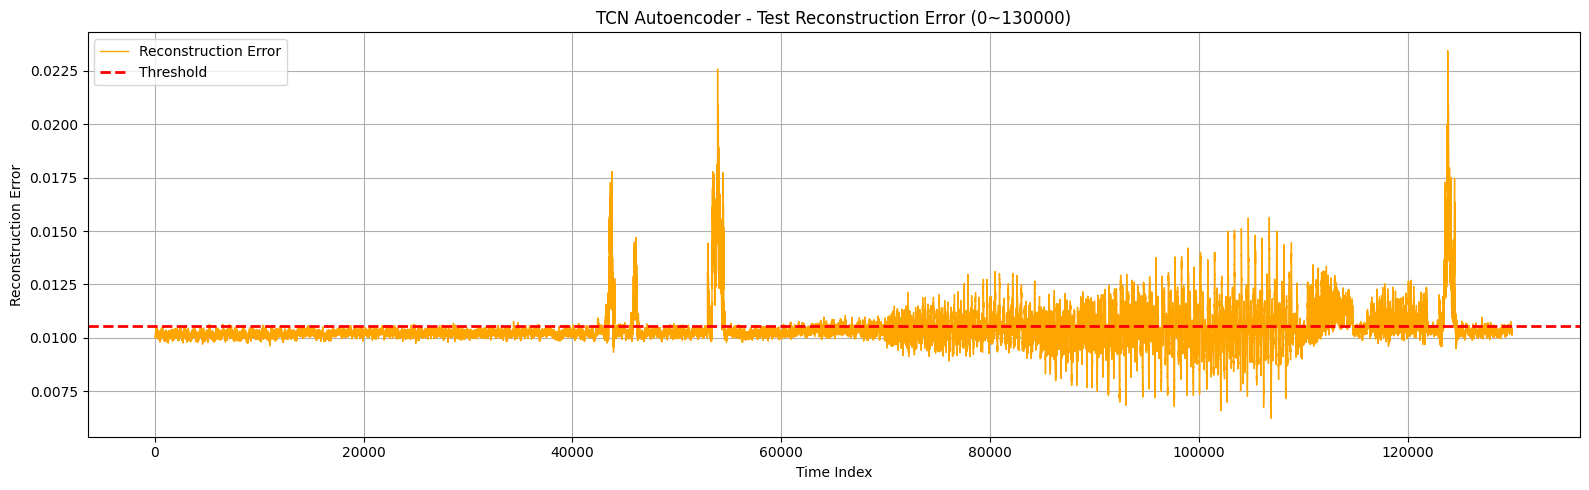

In [10]:
# =====================
# 8. 시각화
# =====================
positions = np.arange(seq_len, 130000)

plt.figure(figsize=(16, 5))
plt.plot(positions, test_errors, label="Reconstruction Error", color='orange', linewidth=1)
plt.axhline(threshold, color='red', linestyle='--', linewidth=2, label='Threshold')
plt.title("TCN Autoencoder - Test Reconstruction Error (0~130000)")
plt.xlabel("Time Index")
plt.ylabel("Reconstruction Error")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



=== Filtered Anomaly Detection Performance (based on filtered_anomalies) ===
              precision    recall  f1-score   support

      Normal       0.79      1.00      0.88    102587
     Anomaly       0.00      0.00      0.00     27349

    accuracy                           0.79    129936
   macro avg       0.39      0.50      0.44    129936
weighted avg       0.62      0.79      0.70    129936

ROC-AUC: 0.5000
PR-AUC (Average Precision): 0.2105


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


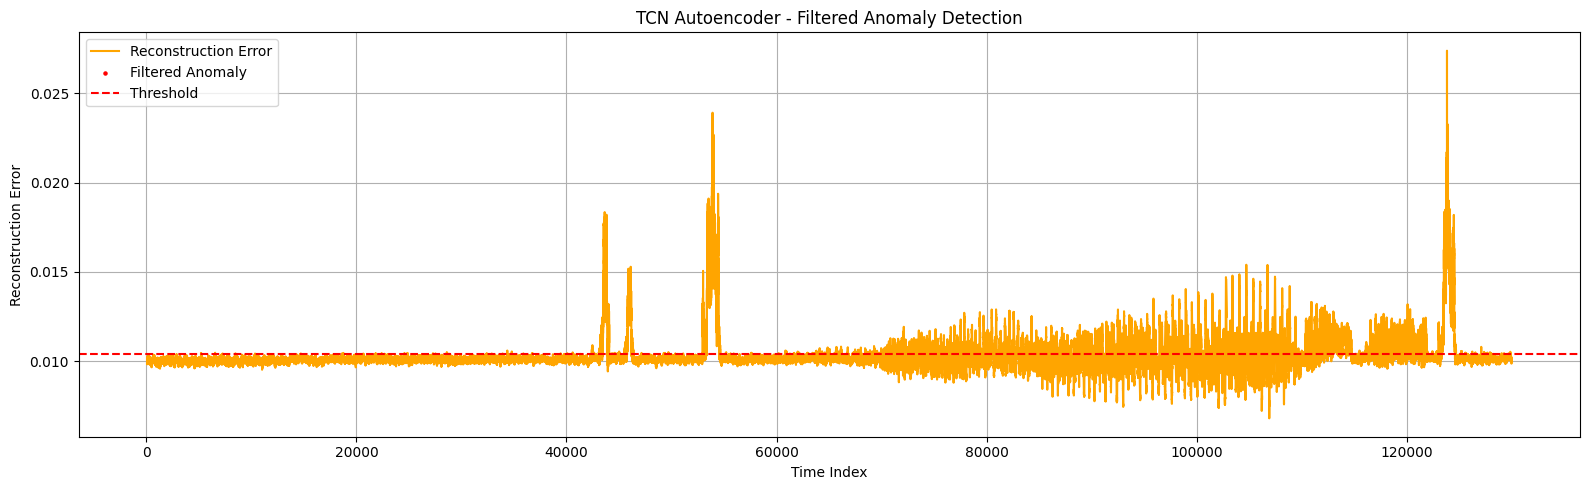

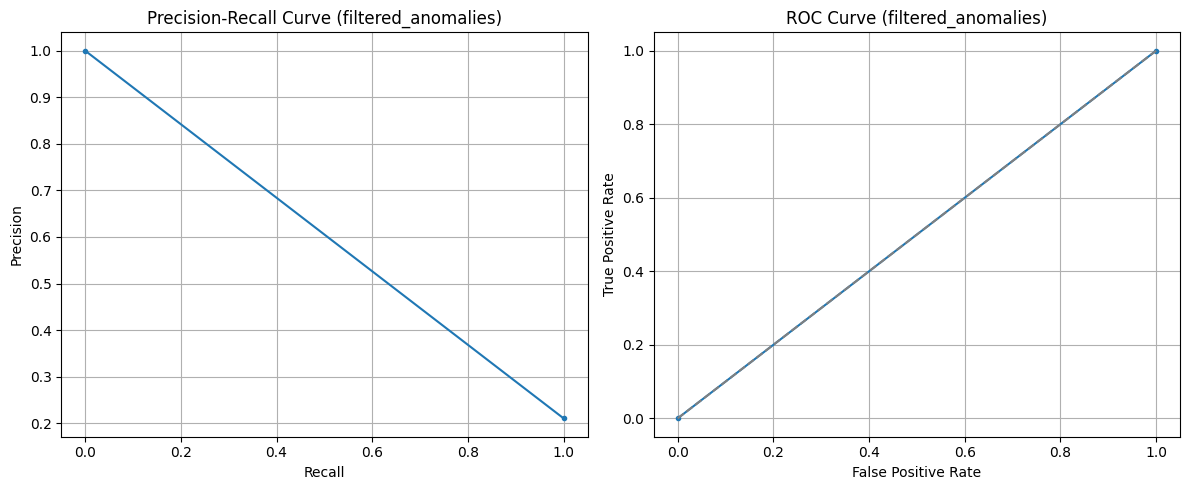

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

# =====================
# 9. 라벨링 기반 성능 평가
# =====================

# 원본 noise로부터 라벨 생성
data = pd.read_csv("CNCnoise_1.csv", header=None)
data.columns = ['noise']

# 이동평균 및 평균 차이
rolling_n = 3
data['bnd_average'] = data['noise'].rolling(window=rolling_n).mean().fillna(data['noise'])
data['diff_noise_average'] = data['noise'] - data['bnd_average']

# Z-score 기반 이상치
data['z_score'] = (data['diff_noise_average'] - data['diff_noise_average'].mean()) / data['diff_noise_average'].std()
data['is_outlier_z'] = abs(data['z_score']) > 10

# IQR 기반 이상치
Q1 = data['diff_noise_average'].quantile(0.25)
Q3 = data['diff_noise_average'].quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 25 * IQR
upper = Q3 + 25 * IQR
data['is_outlier_iqr'] = (data['diff_noise_average'] < lower) | (data['diff_noise_average'] > upper)

# 둘 중 하나라도 이상치면 True
data['is_anomaly'] = data['is_outlier_z'] & data['is_outlier_iqr']

# 슬라이딩 윈도우 고려해 test 구간에 해당하는 라벨만 추출
test_labels_raw = data['is_anomaly'].values[:130000]  # bool array
true_labels = test_labels_raw[seq_len:]               # 시퀀스만큼 슬라이싱

# TCN 예측값 (threshold 기준)
pred_labels = np.array([1 if err > threshold else 0 for err in test_errors])

# =====================
# 성능 지표 출력
# =====================
print("=== Anomaly Detection Performance (Z + IQR 기반 라벨) ===")
print(f"Precision: {precision_score(true_labels, pred_labels):.4f}")
print(f"Recall:    {recall_score(true_labels, pred_labels):.4f}")
print(f"F1 Score:  {f1_score(true_labels, pred_labels):.4f}")
print()
print("Classification Report:")
print(classification_report(true_labels, pred_labels, target_names=["Normal", "Anomaly"]))


=== Filtered Anomaly Detection Performance (based on filtered_anomalies) ===
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00    127658
     Anomaly       1.00      0.83      0.91      2278

    accuracy                           1.00    129936
   macro avg       1.00      0.91      0.95    129936
weighted avg       1.00      1.00      1.00    129936

ROC-AUC: 0.9142
PR-AUC (Average Precision): 0.8314


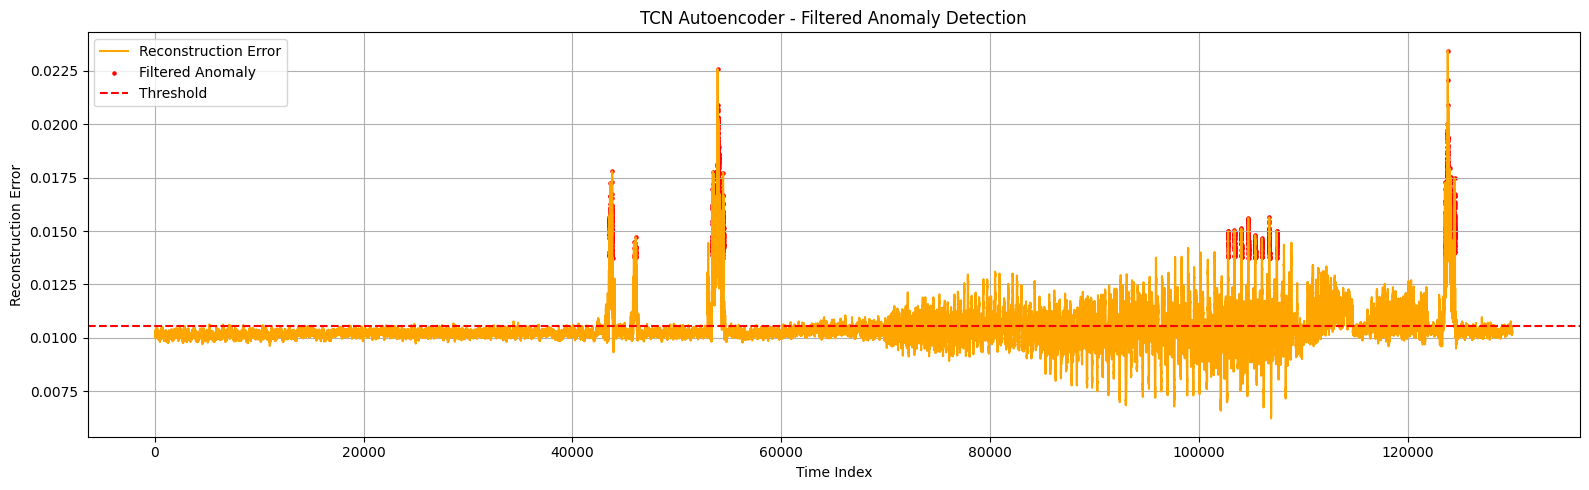

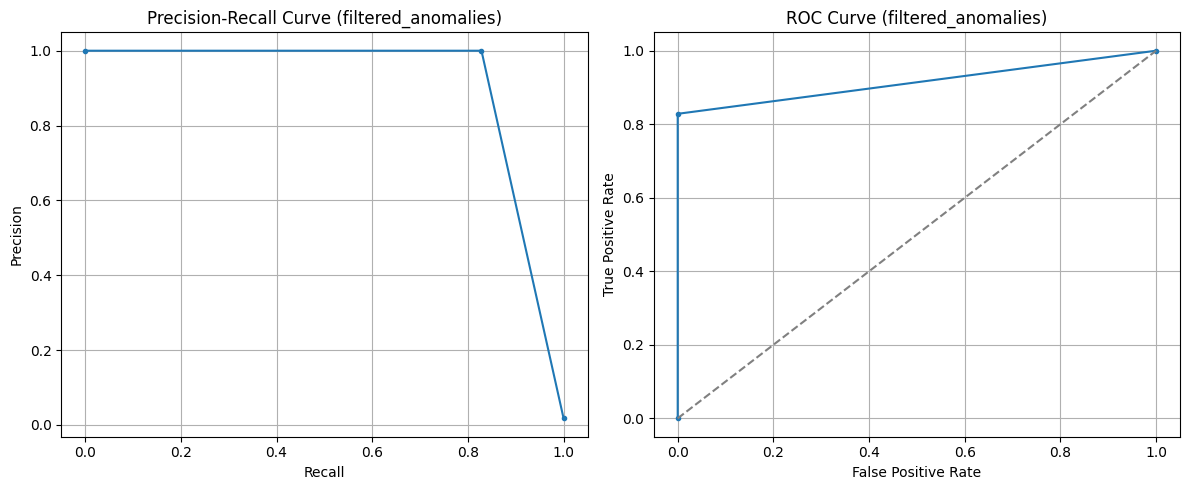

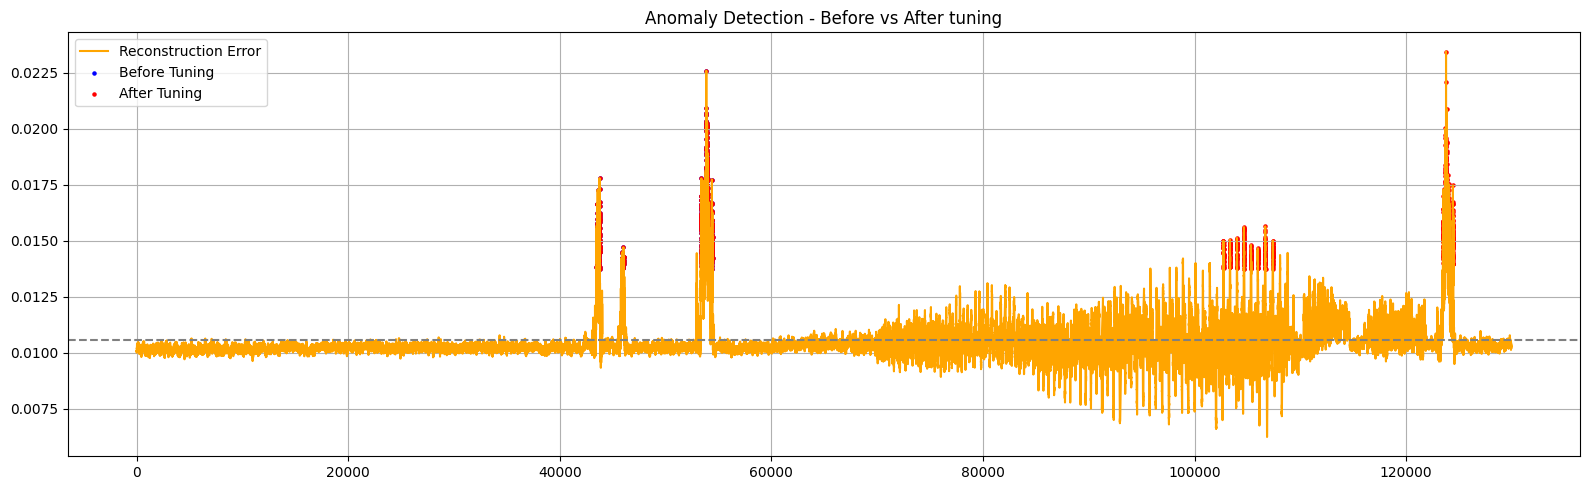

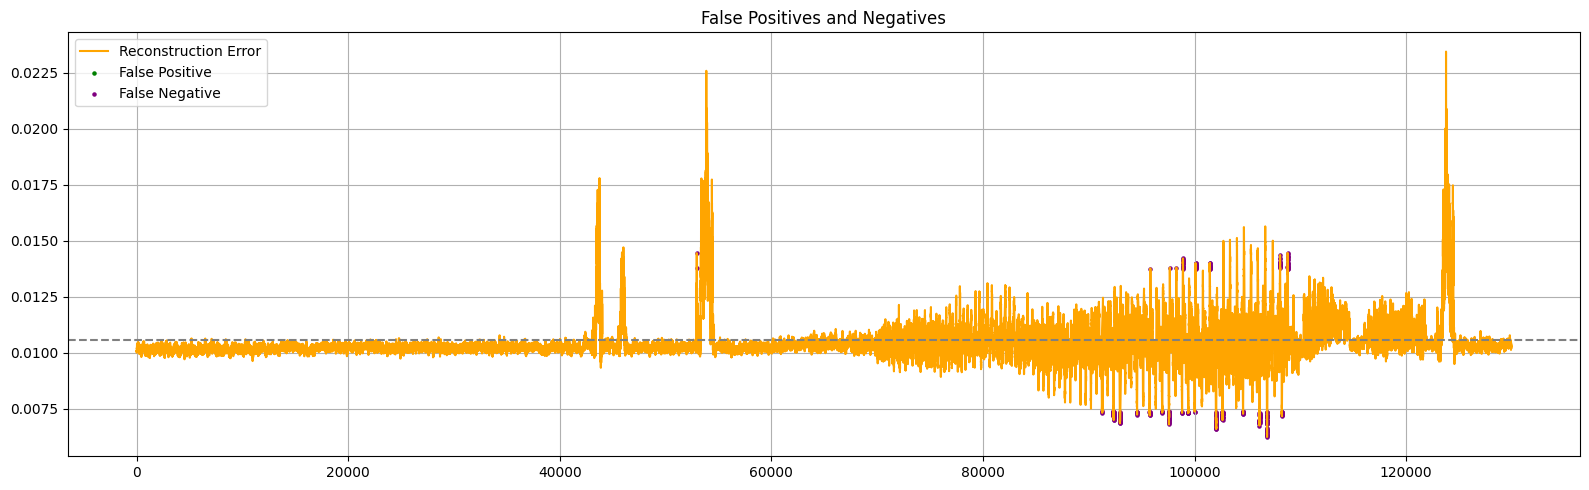

[탐지 구간 수 비교] 이전: 73, 현재: 126


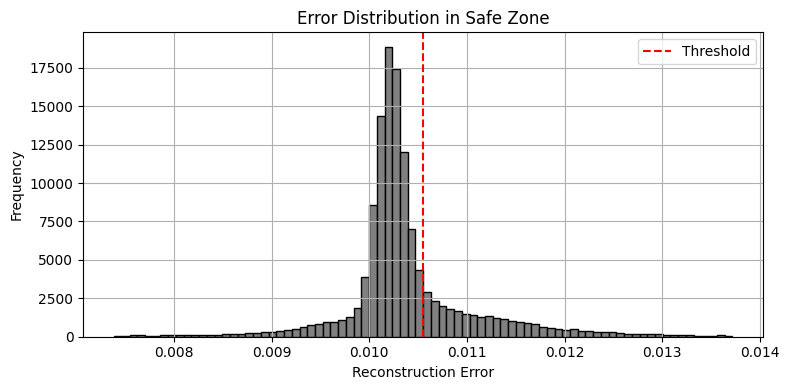

In [27]:
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score, precision_recall_curve, roc_curve

# =====================
# 평가 지표 (filtered_anomalies 기준으로 평가)
# =====================

from scipy.ndimage import label

# === 조건 기반 이상 탐지 ===
is_over_threshold = test_errors > threshold
labeled, num_features = label(is_over_threshold)
test_errors = np.array(test_errors)

# === 필터링 조건 설정 ===
min_len = 5          # 조정 가능
min_std = 0.002      # 조정 가능
min_range = 0.004    # 조정 가능

# === 필터링된 이상 마스크 초기화 ===
filtered_anomalies = np.zeros_like(test_errors, dtype=int)

# === 필터링 루프 ===
for i in range(1, num_features + 1):
    indices = np.where(labeled == i)[0]
    if len(indices) >= min_len:
        segment = test_errors[indices]
        if (np.std(segment) >= min_std) or (np.max(segment) - np.min(segment) >= min_range):
            filtered_anomalies[indices] = 1

# === 기본 pseudo-label 생성 (Z + IQR 기반) ===
z_scores = (test_errors - np.mean(test_errors)) / np.std(test_errors)
z_mask = np.abs(z_scores) > 3
Q1 = np.percentile(test_errors, 25)
Q3 = np.percentile(test_errors, 75)
IQR = Q3 - Q1
iqr_mask = (test_errors < Q1 - 1.5 * IQR) | (test_errors > Q3 + 1.5 * IQR)
pseudo_labels = (z_mask | iqr_mask).astype(int)

# === 완화 조건 적용 ===
from scipy.ndimage import uniform_filter1d

smooth_errors = uniform_filter1d(test_errors, size=30)
gradients = np.abs(np.gradient(smooth_errors))

safe_zone_mask = (
    (test_errors > threshold * 0.7) &  # ← 범위 확대
    (test_errors < threshold * 1.3) &
    (gradients < 0.0002)               # ← gradient 제한 완화
)

pseudo_labels[safe_zone_mask] = 0
filtered_anomalies[safe_zone_mask] = 0

# === 핵심 변경 ===
print("\n=== Filtered Anomaly Detection Performance (based on filtered_anomalies) ===")
print(classification_report(pseudo_labels, filtered_anomalies, target_names=["Normal", "Anomaly"]))

roc_auc = roc_auc_score(pseudo_labels, filtered_anomalies)
ap_score = average_precision_score(pseudo_labels, filtered_anomalies)
print(f"ROC-AUC: {roc_auc:.4f}")
print(f"PR-AUC (Average Precision): {ap_score:.4f}")

# =====================
# 시각화 (Error + Anomaly 위치 표시)
# =====================
positions = np.arange(seq_len, seq_len + len(test_errors))

plt.figure(figsize=(16, 5))
plt.plot(positions, test_errors, label="Reconstruction Error", color='orange')
plt.scatter(positions[filtered_anomalies == 1], test_errors[filtered_anomalies == 1], color='red', s=5, label='Filtered Anomaly')
plt.axhline(threshold, color='red', linestyle='--', label='Threshold')
plt.title("TCN Autoencoder - Filtered Anomaly Detection")
plt.xlabel("Time Index")
plt.ylabel("Reconstruction Error")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# =====================
# PR Curve & ROC Curve (Filtered 결과 기반)
# =====================
precision, recall, _ = precision_recall_curve(pseudo_labels, filtered_anomalies)
fpr, tpr, _ = roc_curve(pseudo_labels, filtered_anomalies)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(recall, precision, marker='.')
plt.title('Precision-Recall Curve (filtered_anomalies)')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(fpr, tpr, marker='.')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title('ROC Curve (filtered_anomalies)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

plt.tight_layout()
plt.show()


# =====================
# 검증 시각화 ①: 탐지 전후 비교
# =====================
# (이전 필터 결과 prev_filtered 예시로 생성)
prev_filtered = np.zeros_like(filtered_anomalies)
prev_filtered[:len(filtered_anomalies) // 2] = filtered_anomalies[:len(filtered_anomalies) // 2]

positions = np.arange(len(test_errors))
plt.figure(figsize=(16, 5))
plt.plot(positions, test_errors, label="Reconstruction Error", color="orange")
plt.scatter(np.where(prev_filtered == 1), test_errors[prev_filtered == 1], label="Before Tuning", s=5, color="blue")
plt.scatter(np.where(filtered_anomalies == 1), test_errors[filtered_anomalies == 1], label="After Tuning", s=5, color="red")
plt.axhline(threshold, linestyle="--", color="gray")
plt.legend()
plt.title("Anomaly Detection - Before vs After tuning")
plt.grid(True)
plt.tight_layout()
plt.show()

# =====================
# 검증 시각화 ②: FP / FN 위치
# =====================
false_positives = (filtered_anomalies == 1) & (pseudo_labels == 0)
false_negatives = (filtered_anomalies == 0) & (pseudo_labels == 1)

plt.figure(figsize=(16, 5))
plt.plot(test_errors, label='Reconstruction Error', color='orange')
plt.scatter(np.where(false_positives)[0], test_errors[false_positives], color='green', label='False Positive', s=5)
plt.scatter(np.where(false_negatives)[0], test_errors[false_negatives], color='purple', label='False Negative', s=5)
plt.axhline(threshold, linestyle='--', color='gray')
plt.legend()
plt.title("False Positives and Negatives")
plt.grid(True)
plt.tight_layout()
plt.show()

# =====================
# 검증 시각화 ③: 이상 탐지 구간 수 비교
# =====================
labeled_prev, num_prev = label(prev_filtered)
labeled_new, num_new = label(filtered_anomalies)
print(f"[탐지 구간 수 비교] 이전: {num_prev}, 현재: {num_new}")

# =====================
# 검증 시각화 ④: Safe Zone 내부 분포
# =====================
plt.figure(figsize=(8, 4))
plt.hist(test_errors[safe_zone_mask], bins=80, color='gray', edgecolor='black')
plt.axvline(threshold, color='red', linestyle='--', label="Threshold")
plt.title("Error Distribution in Safe Zone")
plt.xlabel("Reconstruction Error")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
